In [2]:
from pyspark.sql.functions import col, desc, asc
import pyspark.sql.functions as F
import pygeohash as pgh
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

geohashEncodeUDF = F.udf(lambda x, y: pgh.encode(x, y))
geohashDecodeUDF = F.udf(lambda s: pgh.decode(s))

### Strangely Snowy: Find a location that contains snow while its surroundings do not. Why does this occur? Is it a high mountain peak in a desert?
I originally started by looking for all the points in the dataset on Dec 26th, 2016 that had snow and realized there were too many points to look at them all individually. So I looked up a map that let me pick a point and get the lat and long values for the point and picked a spot in Arizona because some areas have snow in winter, but that didn't give me many results so I started looking in the CA/NV border because of the mountain ranges in the area.

I found an area in the Stanislaus National Forest between December 26-29, 2016 that had only one point in a bounding region with a snow depth higher than 0. The area's bounding latitude values were between 37.3-37.8, and its bounding longitude values were -121 and -120. 
The coordinates of the snowy point are 38.021557396033124 lat and -120.00482559776982 long.
The elevation of this point is 4996.6 ft, so it makes sense that the surrounding points with lower elevation would have no snow on them.

In [ ]:
df = spark.read.load('hdfs://orion01:25001/namanl_218_20151010_0000_003.grb.tdv.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:
df.count()

In [ ]:
df.take(1)

In [ ]:
snowy = df.filter(df.snow_depth_surface > 0)
snowy.take(4)

In [ ]:
snowy.count()

In [ ]:
df.createOrReplaceTempView("total")

arizona = spark.sql('SELECT * FROM total WHERE 2_lat > 32 AND 2_lat < 34 AND 3_lon > -111 AND 3_lon < -109 AND snow_depth_surface == 0')

# around = snowy.filter(df.2_lat >= 32 && df.2_lat >= 34).filter(df.3_lon >= -109 && df.3_lon >= -111)

In [ ]:
arizona.count()

In [ ]:
arizona.take(5)

In [ ]:
diablo = spark.sql('SELECT * FROM total WHERE 2_lat > 35 AND 2_lat < 38 AND 3_lon > 120 AND 3_lon < 123 AND snow_depth_surface > 0')
diablo.count()

In [ ]:
#  namanl_218_20161227_1200_003.grb.tdv.gz
dec27 = spark.read.load('hdfs://orion01:25001/namanl_218_201612*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:
dec27.createOrReplaceTempView("december")

wovoka_snow = spark.sql('SELECT * FROM december WHERE 2_lat > 37.5 AND 2_lat < 38.5 AND 3_lon < -118 AND 3_lon > -121 AND snow_depth_surface > 0')
wovoka_dry = spark.sql('SELECT * FROM december WHERE 2_lat > 37.5 AND 2_lat < 38.5 AND 3_lon < -118 AND 3_lon > -121 AND snow_depth_surface = 0')

wovoka = spark.sql('SELECT 2_lat, 3_lon, snow_depth_surface FROM december WHERE 2_lat > 37.5 AND 2_lat < 38.5 AND 3_lon < -118 AND 3_lon > -121')


In [ ]:
wovoka_snow.count()

In [ ]:
wovoka_dry.count()

In [ ]:
wovoka.count()

In [ ]:
wovoka.take(10)

In [ ]:
wovoka.take(75)

In [ ]:
dec27.createOrReplaceTempView("wovoka")

bound = spark.sql('SELECT 2_lat, 3_lon, snow_depth_surface FROM wovoka WHERE 37.3 < 2_lat AND 2_lat < 38.1 AND -121 < 3_lon AND 3_lon < -120')


In [ ]:
bound.count()

In [ ]:
bound.take(168)

#### Climate Chart: Given a Geohash prefix as an input, build a function that will create a climate chart for the region. This includes high, low, and average temperatures, as well as monthly average rainfall (precipitation).

To solve this problem, I imported a few days worth of data from every month in 2016 so that any random fluctuations in weather by week would be accounted for. I then added a column of geohashes so that I could select only the points in each month's dataframes that started with the 2 character geohash, as well as renamed the lat and lon columns to make calculating the geohashes go more smoothly.

My next step was to make a function that would get the necessary data from each of the month dataframes, average them, and then store them in another dataframe that could be saved into a file. This file is read by the chart function that was linked in the project spec, though I did modify it slightly so that it treated the temperatures as though they were in Fahrenheit by default. The charting method then reads teh file and plots teh high, low, and average temperatures per month, as well as the average rainfall per month in inches (the numbers are pretty low, but I think I just chose days that didn't have as much rain...)

In [ ]:
jan = spark.read.load('hdfs://orion01:25001/namanl_218_201601*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

feb = spark.read.load('hdfs://orion01:25001/namanl_218_201602*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

mar = spark.read.load('hdfs://orion01:25001/namanl_218_201603*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

apr = spark.read.load('hdfs://orion01:25001/namanl_218_201604*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

may = spark.read.load('hdfs://orion01:25001/namanl_218_201605*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

jun = spark.read.load('hdfs://orion01:25001/namanl_218_201606*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:
jul = spark.read.load('hdfs://orion01:25001/namanl_218_201607*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

aug = spark.read.load('hdfs://orion01:25001/namanl_218_201608*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

sep = spark.read.load('hdfs://orion01:25001/namanl_218_201609*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

octo = spark.read.load('hdfs://orion01:25001/namanl_218_201610*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

nov = spark.read.load('hdfs://orion01:25001/namanl_218_201611*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

dec = spark.read.load('hdfs://orion01:25001/namanl_218_201612*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:


jan = jan.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jan = jan.withColumn("geohash", geohashEncodeUDF(jan.lat, jan.lon))

feb = feb.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
feb = feb.withColumn("geohash", geohashEncodeUDF(feb.lat, feb.lon))

mar = mar.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
mar = mar.withColumn("geohash", geohashEncodeUDF(mar.lat, mar.lon))

apr = apr.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
apr = apr.withColumn("geohash", geohashEncodeUDF(apr.lat, apr.lon))

may = may.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
may = may.withColumn("geohash", geohashEncodeUDF(may.lat, may.lon))

jun = jun.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jun = jun.withColumn("geohash", geohashEncodeUDF(jun.lat, jun.lon))

jul = jul.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
jul = jul.withColumn("geohash", geohashEncodeUDF(jul.lat, jul.lon))

aug = aug.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
aug = aug.withColumn("geohash", geohashEncodeUDF(aug.lat, aug.lon))

sep = sep.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
sep = sep.withColumn("geohash", geohashEncodeUDF(sep.lat, sep.lon))

octo = octo.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
octo = octo.withColumn("geohash", geohashEncodeUDF(octo.lat, octo.lon))

nov = nov.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
nov = nov.withColumn("geohash", geohashEncodeUDF(nov.lat, nov.lon))

dec = dec.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
dec = dec.withColumn("geohash", geohashEncodeUDF(dec.lat, dec.lon))
    
jan.take(1)

In [ ]:
def climate_chart(months, geohash):
    avgs = pd.DataFrame()

    avgs['month'] = None
    avgs['h_temp'] = None
    avgs['l_temp'] = None
    avgs['avg_precip'] = None
    avgs['avg_temp'] = None
    
    
    for i in range(0, len(months)):
        min_temp = months[i].select(min(when(months[i].geohash.startswith(geohash), months[i].temperature_surface)).alias("min_temp"))
        max_temp = months[i].select(max(when(months[i].geohash.startswith(geohash), months[i].temperature_surface)).alias("max_temp"))
        avg_temp = months[i].select(avg(when(months[i].geohash.startswith(geohash), months[i].temperature_surface)).alias("avg_temp"))
        avg_rain = months[i].select(avg(when(months[i].geohash.startswith(geohash), months[i].total_precipitation_surface_3_hour_accumulation)).alias("avg_rain"))

        # <month-num>  <high-temp>  <low-temp>  <avg-precip>  <avg-temp>
        data = [i+1, k2f(max_temp.head().max_temp), k2f(float(min_temp.head().min_temp)), \
                   avg_rain.head().avg_rain, k2f(avg_temp.head().avg_temp)]
        
        avgs.loc[len(avgs.index)] = data
        
    return avgs  

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import rc

def c2f(t):
    return (t*9/5.0)+32

def k2c(t):
    return t-273.15

def k2f(t):
    return (t*9/5.0)-459.67

#------------------------------------------------------------------------------------#

def climate_map(filename):
    with open(filename, 'r') as f:
        first_line = f.readline()[1:].strip()
        lines = (line for line in f if not line.startswith(','))
        data = np.loadtxt(lines, delimiter=' ')
        
    data = data[:, 1:]
    
    data[:, 0] = data[:, 0] - 1
    data[:, 3] = data[:, 3] * 0.0393701

    plt.ion()
    plt.clf()
    fig = plt.figure(1)
    fig.subplots_adjust(hspace=.20)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1.75, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)
    plt.setp(ax0.get_xticklabels(), visible=False) # disable upper axis label

    ax0.patch.set_facecolor('None')
    ax1.patch.set_facecolor('None')
    
    title = "Climate Overview"

    plt.suptitle(title, fontsize=14)

    y = 0
    ax0.plot([0, data[:, 0].max() + 1], [y, y], zorder=-1, color='#888888',
                alpha=.75, dashes=(8, 2))

    rects0 = ax0.bar(.35 + data[:, 0], data[:, 2] - data[:, 1], bottom=data[:, 1],
            width=.6, color='#df3c3c', edgecolor='#731515')

    rects1 = ax1.bar(.35 + data[:, 0], data[:, 3], color='#1b7edb', width=.6,
            edgecolor='#1d4871')
    
    print(data[:,3])

    plt.xticks(np.arange(0,12) + .4, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
        rotation=30)

    ax0.spines['left'].set_visible(True)
    ax1.spines['left'].set_visible(True)

    for tic in ax0.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    for tic in ax0.yaxis.get_major_ticks():
        tic.tick2On = False

    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False

    for tic in ax1.yaxis.get_major_ticks():
        tic.tick2On = False

    for rect in rects1:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., 1.08*height,
            '%.2f' % (height), ha='center', va='bottom', color='#1d4871')

    for r, rect in enumerate(rects0):
        height = rect.get_height()
        print(height)
        ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 1.08*height,
            '%d' % int(height + rect.get_y()), ha='center', va='bottom',
            color='#731515')
        ax0.text(rect.get_x() + rect.get_width()/2., rect.get_y() - 2,
            '%d' % int(rect.get_y()), ha='center', va='top', color='#731515')
        ax0.plot([rect.get_x() + .05, rect.get_x() + rect.get_width() - .05],
                [data[r, 4], data[r, 4]], color='#731515')

    ax0.set_ylabel('Temperature (F)')
    ax1.set_ylabel('Precipitation (in)')

    plt.savefig('climate.pdf', bbox_inches='tight')

In [ ]:
months = [jan, feb, mar, apr, may, jun, jul, aug, sep, octo, nov, dec]

avgs = climate_chart(months=months, geohash='dj')

In [ ]:
avgs.head(12)
# print(len(avgs))

In [ ]:
avgs.to_csv('avgs.csv',sep=' ')

In [ ]:
climate = climate_map('avgs.csv')

# plt.show()

#### Fogless Mansion: After becoming rich from your startup, you are looking for the perfect location to build your Bay Area mansion with unobstructed views. Find the locations that are the least foggy and show them on a map.

My first step to solve this problem was to import all of the plotting libraries from matplotlib and pandas. I then renamed the columns for latitude and longitude so that I wouldn't get errors from having ints in the column names when referencing them. I found the general latitude and longitude box for the bay area and started filtering the dataset with those values. 

I chose to have the ```visibility_surface``` of the point be higher than 24000m for the best visibility possible, and I found about 4400 points that way. Sadly, this set of results was not very good and when plotted gave really weird results with arcing lines of high visibility, so I scrapped it and adjusted my filter parameters.

My second test added a few more files from the summer of 2016 when the fog levels would be highest between June and August rather than just July in the first time around.

In [ ]:
df = df.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")


In [ ]:
df.take(1)

In [ ]:
df.createOrReplaceTempView("df")

clear = spark.sql('SELECT lat, lon, visibility_surface FROM df WHERE visibility_surface > 24000 \
                    AND 38 > lat AND lat > 37 AND 122 > lon AND 120 > 37')



In [ ]:
clear.count()

In [ ]:
clear = clear.sort("lon")

In [ ]:
clear.take(10)

In [ ]:
clear_df = clear.toPandas()

clear_df.plot(x="lon", y="lat", kind="scatter", c="visibility_surface",
        colormap="YlOrRd")

In [ ]:
summer = spark.read.load('hdfs://orion01:25001/namanl_218_20160*0600*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

In [ ]:
summer = summer.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")

summer.createOrReplaceTempView("summer")

summ = spark.sql('SELECT lat, lon, visibility_surface FROM summer WHERE 24000 > visibility_surface \
                    AND visibility_surface > 19000 AND 40 > lat AND lat > 36 AND -120 > lon AND lon > -125')

In [ ]:
summ.count()

In [ ]:
summ_df = summ.toPandas()


In [ ]:
summ_df = summ_df.sort_values(by='lon', ascending=True)

summ_df.head()


In [ ]:
summ.take(10)

In [ ]:
summ_df.plot(x="lon", y="lat", kind="scatter", c="visibility_surface",
        colormap="YlOrRd")

In [ ]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

x = summ_df['lon']
y = summ_df['lat']

plt.scatter(x, y, s=z/20000, c=z, cmap='RdPu')

plt.colorbar(label='visibility_surface')

plt.xlim([-128, -118])
plt.ylim([35, 42.5])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

### SolarWind, Inc.: 
#### After getting rich from your travel startup you get bored and start a new company; here, you want to help power companies plan out the locations of solar and wind farms across North America. Locate the top 3 places for solar and wind farms, as well as a combination of both (solar + wind farm). You will report a total of 9 Geohashes as well as their relevant attributes (for example, cloud cover and wind speeds).

For this problem, I stored all the files at 12pm for the entire 2019 data folder because there are valid `wind_speed_gust_surface` and `total_cloud_cover_entire_atmosphere_single_layer` values for 2019. I had to abandon my favorite 2016 dataset :'(

The next thing I did was try a few different ranges of wind gust speeds to filter on in North America, but ultimately decided on 50-70mph so that it was still a somewhat common speed. Some geohashes that were the best for wind farms based on these critera are *9wm6619rmzpp* (69.85mph), *9vqengzgyf40* (69.91mph), and *9xhukcmqdyt8* (69.87mph), all of which were not in the middle of the ocean (because that was a susprisingly annoying problem I kept running into).

I followed the same steps for cloud coverage (low cloud coverage means high sun exposure for solar panels) and eventually settled on a cloud coverage range of 0-15%. This was a bit harder to settle on because of duplicate points from all the files, but to fix that I aggreggated the average cloud coverage of all the points by geohash, this way I was sure that there was only one entry per location, and it could give a baseline estimate for yearly sun exposure. Three geohashes with low cloud coverage that could have solar energy farms are *djv29jbe3xt4* (0%), *dryzdfv0h5ke* (0%), and *9qn4n86pqg6g* (0%).

To find locations where combo wind and solar farms could be built, I combined both of the matching criteria for wind and solar farms into one dataset from 2019. From here i found another 3 geohashes that would be suitable: *9xmfjt08b78u* (50.03mph wind, 0% cloud cover), *9xqjvg1hwpmu* (50.03mph, 0%), and *9wht5bzj7k0v* (50.04mph, 0%).

In [3]:
df = spark.read.load('hdfs://orion01:25001/2019/namanl_218_2019*.gz',
                     format='csv',
                     sep='\t',
                     inferSchema='true',
                     header='true')

df = df.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")


In [4]:
# df = df.withColumn("wind_speed", df.pressure_maximum_wind * 0.00256) # convert wind pressure to wind speed (mph)
df = df.withColumn("wind_speed_gust_surface", df.wind_speed_gust_surface * 2.23694) # convert gust speed to mph

df = df.withColumn("geohash", geohashEncodeUDF(df.lat, df.lon))

In [5]:
# df = df.sort("total_cloud_cover_entire_atmosphere_single_layer")

# df = df.sort("albedo_surface")

df.take(1)

[Row(time=1554908400000, lat=58.424226538128224, lon=-88.11817117586963, albedo_surface=65.0, precipitable_water_entire_atmosphere_single_layer=2.476626, pressure_maximum_wind=30110.812, pressure_surface=103734.39, pressure_tropopause=26750.041, relative_humidity_zerodegc_isotherm=85.0, snow_depth_surface=0.05, temperature_surface=265.12515, temperature_tropopause=212.71329, total_cloud_cover_entire_atmosphere_single_layer=15.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=0.0, visibility_surface=24100.0, wilting_point_surface=0.0, wind_speed_gust_surface=3.176638900162, _c18=None, geohash='f43k6gf3cc1q')]

In [6]:
df.createOrReplaceTempView("farms")


# wind.count()


In [ ]:
wind = spark.sql('SELECT * FROM farms WHERE 70 > wind_speed_gust_surface AND wind_speed_gust_surface > 50 \
AND 24 < lat AND lat < 50 AND -66 > lon AND lon > -124')


In [168]:
wind.count()

123833

In [169]:
hashes = wind.groupBy("geohash")\
            .agg(F.avg("wind_speed_gust_surface").alias("wind_speed"), \
                F.avg("lat").alias("lat"), F.avg("lon").alias("lon"))

# 

In [170]:
wind_df = hashes.toPandas()

In [177]:
wind_df.count()

geohash       41975
wind_speed    41975
lat           41975
lon           41975
dtype: int64

/tmp/ipykernel_278941/2266684143.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


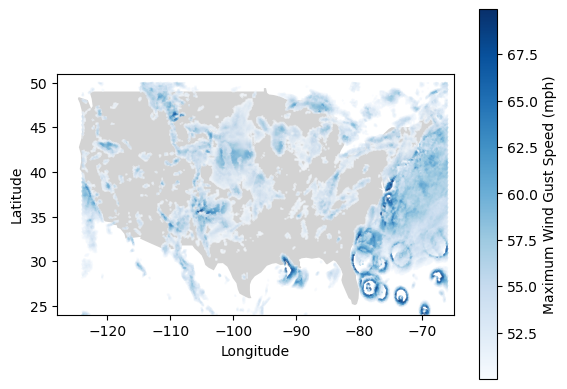

In [176]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = wind_df['lon']
y = wind_df['lat']
z = wind_df['wind_speed']
plt.scatter(x, y, s=z/1000, c=z, cmap='Blues')

plt.colorbar(label='Maximum Wind Gust Speed (mph)')

plt.xlim([-128, -65])
plt.ylim([24, 51])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [10]:
sun = spark.sql('SELECT * FROM farms WHERE total_cloud_cover_entire_atmosphere_single_layer < 15 AND \
        24 < lat AND lat < 50 AND -66 > lon AND lon > -124')

sun = sun.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
sun = sun.withColumn("geohash", geohashEncodeUDF(df.lat, df.lon))

sun.count()
# 60 < albedo_surface AND \

16162739

In [11]:
hashes = sun.groupBy("geohash").agg(\
                                    F.avg("total_cloud_cover_entire_atmosphere_single_layer").alias("cloud_cover"), \
                                    F.avg("lat").alias("lat"), F.avg("lon").alias("lon"))

hashes.limit(5).show()

+------------+------------------+------------------+-------------------+
|     geohash|       cloud_cover|               lat|                lon|
+------------+------------------+------------------+-------------------+
|dj7mfwdn9726| 1.451086956521739| 30.57883134476529| -85.31702351348319|
|f2r487vvgzuf|1.7153846153846153| 46.86733148695685| -68.88719966764627|
|9qyf9scpq43x| 1.178082191780822|38.435553516844195|-114.19026141361283|
|9y2snm4fvghs|0.8217821782178217| 35.88732974349854|-100.26818742903562|
|dh2f0nc9sqyx|1.6770186335403727|24.295186237731336| -88.94306130812514|
+------------+------------------+------------------+-------------------+



In [12]:
sun_df = hashes.toPandas()

sun_df.count()

geohash        105672
cloud_cover    105672
lat            105672
lon            105672
dtype: int64

/tmp/ipykernel_278941/205822461.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


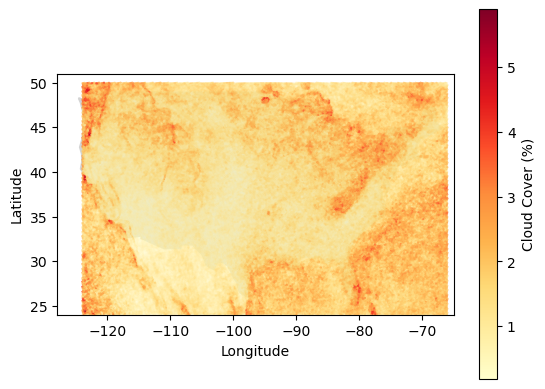

In [113]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = sun_df['lon']
y = sun_df['lat']
z = sun_df['cloud_cover']
plt.scatter(x, y, s=z/25, c=z, cmap='YlOrRd')

plt.colorbar(label='Cloud Cover (%)')

plt.xlim([-128, -65])
plt.ylim([24, 51])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [7]:
farms = spark.sql('SELECT * FROM farms WHERE total_cloud_cover_entire_atmosphere_single_layer < 15 AND \
        70 > wind_speed_gust_surface AND wind_speed_gust_surface > 50 AND \
        24 < lat AND lat < 50 AND -66 > lon AND lon > -124')

farms = farms.withColumnRenamed("1_time", "time").withColumnRenamed("2_lat", "lat").withColumnRenamed("3_lon", "lon")
farms = farms.withColumn("geohash", geohashEncodeUDF(farms.lat, farms.lon))


In [115]:
farms.count()

14789

In [116]:
farms_df = farms.toPandas()

/tmp/ipykernel_278941/3153297965.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


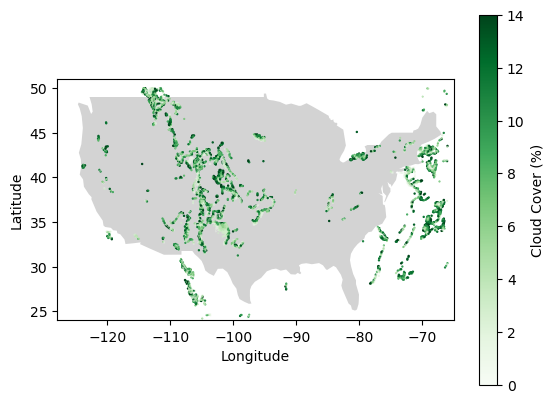

In [120]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
worldmap[worldmap["name"] == "United States of America"].plot(color="lightgrey")

# Plotting our Impact Energy data with a color map
x = farms_df['lon']
y = farms_df['lat']
z = farms_df['total_cloud_cover_entire_atmosphere_single_layer']
# z = farms_df['wind_speed_gust_surface']

plt.scatter(x, y, s=z/25, c=z, cmap='Greens')

plt.colorbar(label='Cloud Cover (%)')

plt.xlim([-128, -65])
plt.ylim([24, 51])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

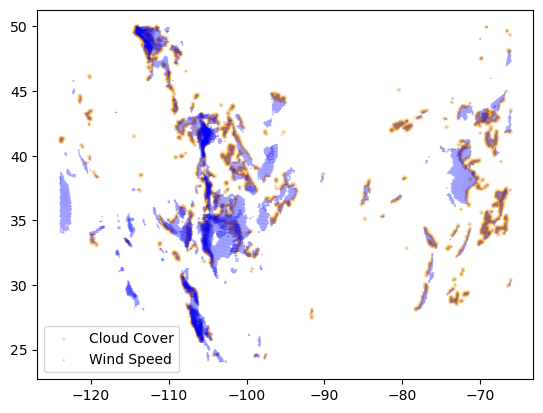

In [179]:
fig, ax = plt.subplots()

ax.scatter(farms_df.lon, farms_df.lat, c="Orange", \
           s=farms_df.total_cloud_cover_entire_atmosphere_single_layer, label="Cloud Cover", \
           alpha=0.3, edgecolors='none')

ax.scatter(farms_df.lon, farms_df.lat, c="Blue", \
           s=farms_df.wind_speed_gust_surface/40, label="Wind Speed", \
           alpha=0.3, edgecolors='none')

ax.legend()

plt.show()

In [180]:
wind.createOrReplaceTempView("wind")
sun.createOrReplaceTempView("sun")

In [183]:
wind = wind.sort(desc("wind_speed_gust_surface"))

In [185]:
wind.take(50)

[Row(time=1547499600000, lat=38.91414277524665, lon=-66.7476671082689, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=26.3, pressure_maximum_wind=16678.62, pressure_surface=99605.11, pressure_tropopause=27510.537, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.0, temperature_surface=292.29138, temperature_tropopause=221.4313, total_cloud_cover_entire_atmosphere_single_layer=100.0, total_precipitation_surface_3_hour_accumulation=37.0, vegetation_surface=0.0, visibility_surface=3100.0, wilting_point_surface=0.0, wind_speed_gust_surface=69.98532985860001, _c18=None, geohash='dwbt3h5g69up'),
 Row(time=1547499600000, lat=39.4112690060248, lon=-66.47143040216878, albedo_surface=6.0, precipitable_water_entire_atmosphere_single_layer=25.4, pressure_maximum_wind=17325.02, pressure_surface=99845.914, pressure_tropopause=26800.938, relative_humidity_zerodegc_isotherm=98.0, snow_depth_surface=0.0, temperature_surface=290.69138, temperature_tropopause=217.8313

In [13]:
sun = sun.sort("total_cloud_cover_entire_atmosphere_single_layer")

In [14]:
sun.take(50)

[Row(time=1551970800000, lat=48.899578819574664, lon=-84.49445311441013, albedo_surface=18.3, precipitable_water_entire_atmosphere_single_layer=2.4727426, pressure_maximum_wind=27199.02, pressure_surface=97782.68, pressure_tropopause=25672.455, relative_humidity_zerodegc_isotherm=53.0, snow_depth_surface=0.16792, temperature_surface=261.0185, temperature_tropopause=212.1, total_cloud_cover_entire_atmosphere_single_layer=0.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=9.7, visibility_surface=24100.0, wilting_point_surface=0.047, wind_speed_gust_surface=19.863300194500003, _c18=None, geohash='f0eyjmch8w1m'),
 Row(time=1551970800000, lat=38.88371753181626, lon=-110.82948162164013, albedo_surface=27.5, precipitable_water_entire_atmosphere_single_layer=8.172743, pressure_maximum_wind=20389.418, pressure_surface=80073.08, pressure_tropopause=20938.055, relative_humidity_zerodegc_isotherm=80.0, snow_depth_surface=0.03488, temperature_surface=275.21848, temperature

In [8]:
farms = farms.sort("total_cloud_cover_entire_atmosphere_single_layer", "wind_speed_gust_surface")

In [9]:
farms.take(50)

[Row(time=1571410800000, lat=40.11324894549836, lon=-97.43991592577913, albedo_surface=18.3, precipitable_water_entire_atmosphere_single_layer=14.354528, pressure_maximum_wind=30396.188, pressure_surface=94755.63, pressure_tropopause=11160.075, relative_humidity_zerodegc_isotherm=8.0, snow_depth_surface=0.0, temperature_surface=287.06793, temperature_tropopause=203.09998, total_cloud_cover_entire_atmosphere_single_layer=0.0, total_precipitation_surface_3_hour_accumulation=0.0, vegetation_surface=33.6, visibility_surface=24100.0, wilting_point_surface=0.084, wind_speed_gust_surface=50.0032481501, _c18=None, geohash='9z4snwqkt7sd'),
 Row(time=1571410800000, lat=40.331186712924755, lon=-96.89115013323169, albedo_surface=18.3, precipitable_water_entire_atmosphere_single_layer=14.354528, pressure_maximum_wind=29671.387, pressure_surface=95321.234, pressure_tropopause=11343.275, relative_humidity_zerodegc_isotherm=9.0, snow_depth_surface=0.0, temperature_surface=287.26794, temperature_tropop

#### Climate Change: Using two-character geohash aggregates across the entire NAM grid, determine temperature trends over the past 5 years. With the regions that have experienced an increase in temperatures, build a correlation matrix using Pearson’s correlation coefficient (PCC) to determine how the variables influence one another. Finally, determine whether or not the correlations are different based on the region (e.g., maybe temperature has increased in lockstep with humidity in one location but not another). Analyze your results: can you draw any conclusions from what you’ve found?

#### Weather Station: Write a multi-threaded server (outside of Spark) that reads files from the dataset — one file per thread — and then streams them out on a socket for a Spark streaming context to consume (note: not ALL the files have to be opened at once! :-)). The program should produce records as fast as the network will support, i.e., faster than real time. 

####

In [ ]:
# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sampleVariance)